# 9. Stochastic Methods: Exercise Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Integration

When an explicit function like $x_n = g(x_1,...,x_{n-1})$ is not available, you can use a binary function that takes 1 within and 0 outside of a region to measure its volume.

1) Measure the volume of an n-dimensional sphere using a binary function
$$ f(x) = \left\{ \begin{array}{ccc}
    1 & \mbox{if} & \sum_{i=1}^n x_i^2 \le 1 \\
    0 & \mbox{otherwise} & \end{array}\right. $$

In [2]:
from scipy.special import gamma

In [3]:
m = 10000
N = 15
x = np.random.random((N, m)) # one quadrant
vol = np.zeros((N+1, 3))  # estimate by two methods
for n in range(2, N+1):
    # by height
    h2 = 1 - np.sum(x[:n-1]**2, axis=0)
    vol[n,0] = 2**n*np.sum(np.sqrt((h2>0)*h2))/m
    # by in/out
    r = np.sum(x[:n]**2, axis=0)
    vol[n,1] = 2**n*np.sum(r<=1)/m
    # theoretical value
    vol[n,2] = 2*np.pi**(n/2)/gamma(n/2)/n
print(vol)

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [3.1426083  3.1732     3.14159265]
 [4.21735336 4.22       4.1887902 ]
 [4.97220452 5.0944     4.9348022 ]
 [5.34897424 5.4592     5.26378901]
 [5.30303448 5.504      5.16771278]
 [4.89789641 4.7616     4.72476597]
 [4.07214441 3.8656     4.05871213]
 [3.3181883  3.5328     3.2985089 ]
 [2.61885875 2.7648     2.55016404]
 [2.06971925 2.2528     1.88410388]
 [1.6675354  0.8192     1.33526277]
 [0.48434363 0.8192     0.91062875]
 [0.07989026 0.         0.59926453]
 [0.         0.         0.38144328]]


2) Measure the area or volume of a shape of your interest by sampling method.

A donut of the hole radius $r0$ and outer radius $r1$.

In [4]:
m = 10000
r0 = 2  # hole radius
r1 = 6  # outer radius 
R = (r0+r1)/2  # radius of the center of the tube
r = (r1-r0)/2  # radius of the tube
x = np.random.random((3, m))  # to be scaled [r1,r1,r]
d = np.sqrt((r1*x[0])**2 + (r1*x[1])**2)  # horizontal distance from center
vol = 8*r1*r1*r*np.sum((d-R)**2 + (r*x[2])**2 <= r**2)/m  # within the tube?
print(vol)

307.8144


## 2. Rejection Sampling
Let us generate samples from Gamma distribution 
$$ p(x; k, \theta) = \frac{1}{\Gamma(k)\theta^k}x^{k-1}e^{-\frac{x}{\theta}} $$
with the shape parameter $k>0$ and the scaling parameter $\theta$ using the gamma function $\Gamma(k)$ available in `scipy.special`.

In [5]:
from scipy.special import gamma
from scipy.special import factorial

Here is how the gamma function looks like, together with factorial at integer values.

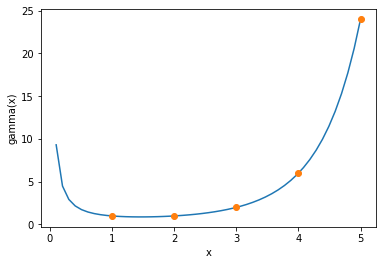

In [6]:
kmax = 5
x = np.linspace(0, kmax, 50)
plt.plot(x, gamma(x))
plt.plot(range(1,kmax+1), [factorial(k-1) for k in range(1,kmax+1)], 'o')
plt.xlabel('x'); plt.ylabel('gamma(x)');

1) Define the Gamma density function with arbitrary $k$ and $\theta$.

In [7]:
def p_gamma(x, k=1, theta=1):
    """density function of gamma distribution"""
    return(x**(k-1)*np.exp(-x/theta)/(gamma(k)*theta**k)) 

Consider the exponential distribution $q(x;\mu)=\frac{1}{\mu}e^{-\frac{x}{\mu}}$ as the proposal distribution.  

In [8]:
def p_exp(x, mu=1):
    """density function of exponential distribution"""
    return(np.exp(-x/mu)/mu)
def x_exp(n=1, mu=1):
    """sample from exponential distribution"""
    y = np.random.random(n)  # uniform in [0,1]
    return(-mu*np.log(1 - y))

The ratio of the target and proposal distributions is
$$ \frac{p(x;k,\theta)}{q(x;\mu)} = \frac{\mu}{\Gamma(k)\theta^k}x^{k-1}e^{(\frac{1}{\mu}-\frac{1}{\theta})x}. $$
By setting
$$ \frac{d}{dx}\frac{p(x;k,\theta)}{q(x;\mu)} = 0 $$
we have
$$ \{(k-1)x^{k-2}+(\frac{1}{\mu}-\frac{1}{\theta})x^{k-1}\}e^{(\frac{1}{\mu}-\frac{1}{\theta})x} = 0. $$
Thus at
$$ x = \frac{(k-1)\mu\theta}{\mu-\theta} $$
the ratio $\frac{p(x;k,\theta)}{q(x;\mu)}$ takes the maximum
$$ \frac{\mu^k}{\Gamma(k)\theta}\left(\frac{k-1}{\mu-\theta}\right)^{k-1}e^{1-k}. $$
2) What is a good choice of $\mu$ to satisfy  $p(x)\le cq(x)$ and what is the value of $c$ for that?

By setting $\mu=k\theta$, we have $p(x)\le cq(x)$ with
$c=\frac{k^k}{\Gamma(k)}e^{1-k}$

3) Verify that $cq(x)$ covers $p(x)$ by plotting them for some $k$ and $\theta$.

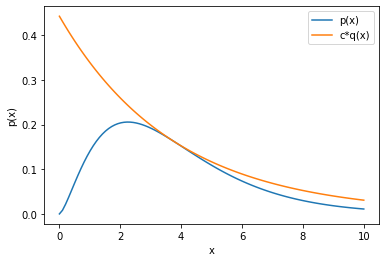

In [9]:
k = 2.5
theta = 1.5
c = (k**k)/gamma(k)*np.exp(1-k)
x = np.linspace(0, 10, 100)
plt.plot(x, p_gamma(x, k, theta), label='p(x)')
plt.plot(x, c*p_exp(x, k*theta), label='c*q(x)')
plt.xlabel('x'); plt.ylabel('p(x)'); plt.legend();

4) Implement a function to general samples from Gamma distribution with arbitorary $k$ and $\theta$ using rejection sampling from exponential distribution.

In [10]:
def x_gamma(n=1, k=1, theta=1):
    """sample from gamma distribution by rejection sampling"""
    c = (k**k)/gamma(k)*np.exp(1-k)
    #print("c =", c)
    xe = x_exp(n, k*theta)
    paccept = p_gamma(xe, k, theta)/(c*p_exp(xe, k*theta))
    accept = np.random.random(n)<paccept
    xg = xe[accept]  # rejection sampling
    #print("accept rate =", len(xg)/n)
    return(xg)

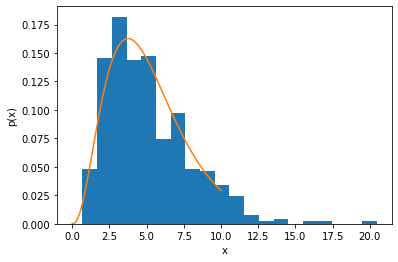

In [11]:
k = 3.5
theta = 1.5
xs = x_gamma(1000, k, theta)
plt.hist(xs, bins=20, density=True)
x = np.linspace(0, 10, 100)
plt.plot(x, p_gamma(x, k, theta))
plt.xlabel('x'); plt.ylabel('p(x)');

## 3. Importance Sampling
You have $m$ sample values $f(x_i)$ $(i=1,...m)$ at $x_i$ following a normal distribution 
$$ q(x;\mu_0,\sigma_0) = \frac{1}{\sqrt{2\pi \sigma_0^2}}e^{-\frac{(x-\mu_0)^2}{2\sigma_0^2}}. $$

Consider estimating the mean of $f(x)$ for samples with a different normal distribution $p(x;\mu_1, \sigma_1)$ by importance sampling
$$ E_p[h(x)] = E_q\left[\frac{p(x)}{q(x)}h(x)\right] $$

1) What is the importance weight $\frac{p(x)}{q(x)}$?

$$\frac{\sigma_0}{\sigma_1}e^{\frac{(x-\mu_0)^2}{2\sigma_0^2}-\frac{(x-\mu_1)^2}{2\sigma_1^2}} $$

2) Let us consider the simplest case of $f(x)=x$. 

Generate $m=100$ samples with $\mu_0=100$ and $\sigma_0=20$ and take the sample mean $E_q[f(x)]$.

In [12]:
def f(x):
    return x

In [13]:
def normal(x, mu=0, sig=1):
    """normal distribution function"""
    return np.exp(-((x-mu)/sig)**2/2)/(np.sqrt(2*np.pi)*sig)

100.97189584336346


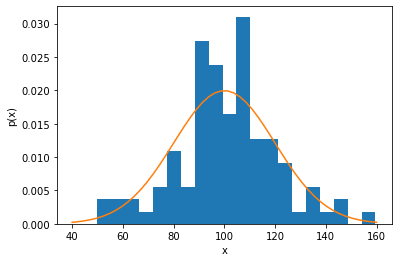

In [14]:
m = 100
mu0 = 100
sig0 = 20
xs = mu0 + sig0*np.random.randn(m)
plt.hist(xs, bins=20, density=True)
print(np.mean(f(xs)))
x = np.linspace(mu0-3*sig0, mu0+3*sig0)
plt.plot(x, normal(x, mu0, sig0))
plt.xlabel('x'); plt.ylabel('p(x)');

3) Estimate the mean $E_p[f(x)]$ for $\mu_1=120$ and $\sigma_1=10$ by importance sampling.

109.0703725322866


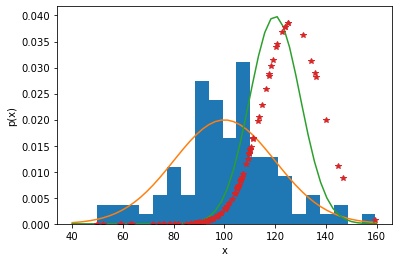

In [15]:
mu1 = 120
sig1 = 10
importance = sig0/sig1*np.exp((xs-mu0)**2/(2*sig0**2)-(xs-mu1)**2/(2*sig1**2))
mean1 = np.mean(importance*f(xs))
print(mean1)
plt.hist(xs, bins=20, density=True)
plt.plot(x, normal(x, mu0, sig0))
plt.plot(x, normal(x, mu1, sig1))
plt.plot(xs, importance/100, '*');
plt.xlabel('x'); plt.ylabel('p(x)');

4) See how the result changes with different settings of $\mu_1$, $\sigma_1$ and sample size $m$.

99.2858495974293
119.57648534494304


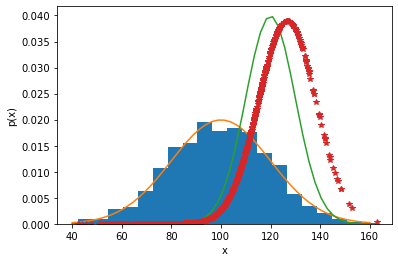

In [16]:
# more samples
m = 1000
xs = mu0 + sig0*np.random.randn(m)
plt.hist(xs, bins=20, density=True)
print(np.mean(f(xs)))
importance = sig0/sig1*np.exp((xs-mu0)**2/(2*sig0**2)-(xs-mu1)**2/(2*sig1**2))
mean1 = np.mean(importance*f(xs))
print(mean1)
plt.plot(x, normal(x, mu0, sig0))
plt.plot(x, normal(x, mu1, sig1))
plt.plot(xs, importance/100, '*');
plt.xlabel('x'); plt.ylabel('p(x)');

100.01819839183136
107.41959219691105


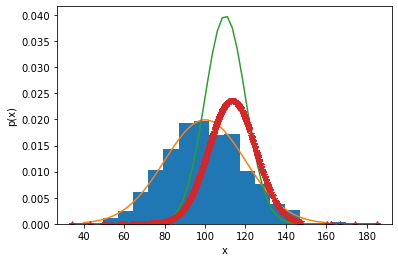

In [17]:
# closer distribution
m = 1000
mu1 = 110
xs = mu0 + sig0*np.random.randn(m)
plt.hist(xs, bins=20, density=True)
print(np.mean(f(xs)))
importance = sig0/sig1*np.exp((xs-mu0)**2/(2*sig0**2)-(xs-mu1)**2/(2*sig1**2))
mean1 = np.mean(importance*f(xs))
print(mean1)
plt.plot(x, normal(x, mu0, sig0))
plt.plot(x, normal(x, mu1, sig1))
plt.plot(xs, importance/100, '*');
plt.xlabel('x'); plt.ylabel('p(x)');

Optional) Try with a different function $f(x)$.

## 4. MCMC

Try applying Metropolis sampling to your own (unnormalized) distribution.

In [18]:
def metropolis(p, x0, sig=0.1, m=1000):
    """metropolis: Metropolis sampling
    p:unnormalized probability, x0:initial point,
    sif:sd of proposal distribution, m:number of sampling"""
    n = len(x0)  # dimension
    p0 = p(x0)
    x = []
    for i in range(m):
        x1 = x0 + sig*np.random.randn(n)
        p1 = p(x1)
        pacc = min(1, p1/p0)
        if np.random.rand()<pacc:
            x.append(x1)
            x0 = x1
            p0 = p1
    return np.array(x)

In [19]:
def donut(x, r0=1, r1=2):
    """donut-like distribution: r0:hole radius, r1:outer radius"""
    R = (r0+r1)/2  # radius of the center of the tube
    r = (r1-r0)/2  # radius of the tube
    d = np.sqrt(x[0]**2 + x[1]**2)  # horizontal distance from center
    #return np.sqrt((d>r0)*(d<r1)*(r**2-(d-R)**2))
    return np.exp(-((d-R)/r)**2)

(-3.0, 3.0, -3.0, 3.0)

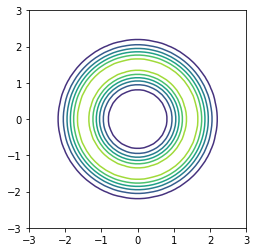

In [20]:
rx = 3  # plot rage
x = np.linspace(-rx, rx)
X, Y = np.meshgrid(x, x)
Z = donut(np.array([X,Y]))
plt.contour(X, Y, Z)
plt.axis('square')

4577


(-3.0, 3.0, -3.0, 3.0)

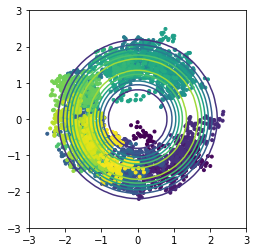

In [23]:
x = metropolis(donut, [0,0], m=5000)
s = len(x); print(s)
plt.contour(X, Y, Z)
plt.scatter(x[:,0], x[:,1], c=np.arange(s), marker='.');
plt.axis('square')